## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda:0'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

**<font color=blue>Observations:</font>**

- We'll build a NN from the simplest one: with only two inner layers. If it doesn't achieve $0.885$, then we'll experiment with other network structure and activation functions.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Linear(500, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                   [-1, 10]           5,010
           Sigmoid-5                   [-1, 10]               0
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.52
Estimated Total Size (MB): 1.53
----------------------------------------------------------------


Your experiments come here:

**<font color=blue>Observations:</font>**

- Disclaimer: The function `train_model` above is largely based on the function with the same name used during `week0_09`.

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []

    train_accuracy = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []

        ep_train_accuracy = []
        ep_val_accuracy = []

        # Turn on the training mode.
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            
            # 1) zero the grads
            opt.zero_grad()
            
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 2) Do forward pass
            out = model(X_batch)

            # 3) Compute loss
            loss = loss_fn(out, y_batch)
            

            # 4) Compute gradients (backward pass)
            loss.backward()
            
            # 5) Compute gradient step (with Adam) 
            opt.step()

            ep_train_loss.append(loss.item())
            # 6) Compute train accuracy
            y_pred = out.max(dim=1)[1]
            ep_train_accuracy.append(np.sum((y_pred.cpu() == y_batch.cpu()).numpy().astype(float))/len(y_batch))
                        
        # Turn of training mode.
        model.train(False) # disable dropout / use moving averages for batch_norm
        # torch.no_grad() in order to save memory.
        with torch.no_grad():
          for X_batch, y_batch in val_loader:

                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # 1) Compute probas
                out = model(X_batch)

                # 2) Compute loss
                loss = loss_fn(out, y_batch)
                ep_val_loss.append(loss.item())

                # 3) Compute predictions
                y_pred = out.max(dim=1)[1]### YOUR CODE HERE
                
                # 4) Compute accuracy
                ep_val_accuracy.append(np.sum((y_pred.cpu() == y_batch.cpu()).numpy().astype(float))/len(y_batch))

        # print the results for this epoch:
        # print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))

        train_accuracy.append(np.mean(ep_train_accuracy))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        # print(f"\t  training loss: {train_loss[-1]:.6f}")
        # print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        # print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, train_accuracy, val_accuracy
    # return train_loss, val_loss, val_accuracy

In [ ]:
def plot_train_process(title, train_loss, val_loss, val_accuracy, train_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle(title, fontsize=24)

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='test')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='test')
    axes[1].legend()

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

In [ ]:
n_epochs = 60
train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

In [ ]:
val_accuracy[-1]

0.88701171875

- $0.887$ in test accuracy is fair enough.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
from torch.utils.data import Subset

In [ ]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [ ]:
small_train_id = subset_ind(fmnist_dataset_train, 0.5)

In [ ]:
len(small_train_id)

30000

In [ ]:
small_train = Subset(fmnist_dataset_train, small_train_id)

In [ ]:
small_train_loader = torch.utils.data.DataLoader(small_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

**<font color=blue>Observations:</font>**

- We are dealing with classification. That is, for a given instance $x$ the output layer will give a vector $\hat{y}_x$ of dimensions `num_classes`. The natural way to proceed would be to use an activation that translates this values to, at least, a symmetric range (if we are using Cross Entropy Loss then the better choice would to use Softmax as activation to bring all the values in $\hat{y}_x$ between $0$ and $1$, giving them the meaning of probability of belonging to a class).
- To generate an overfitting network our attempt consists in using LeakyReLU as the activation function of the output layer. In contrast to that said above, LeakyReLU doesn't bring any meaningful advantage (having Cross Entropy as loss function). Moreover, it dumps negative values in $\hat{y}$ close to zero, which we think may bring some instability at the moment making predictions.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.LeakyReLU(),
            nn.Linear(100, num_classes),
            nn.LeakyReLU()

        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
         LeakyReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 200]         100,200
         LeakyReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 100]          20,100
         LeakyReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
         LeakyReLU-9                   [-1, 10]               0
Total params: 513,810
Trainable params: 513,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.96
Estimated Total Size (MB): 1.98
-------------------------------------------

In [ ]:
del model, opt, loss_func
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here

In [ ]:
n_epochs = 60
del train_loss, val_loss, train_accuracy, val_accuracy
train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, small_train_loader, test_loader, loss_func, opt, n_epochs)

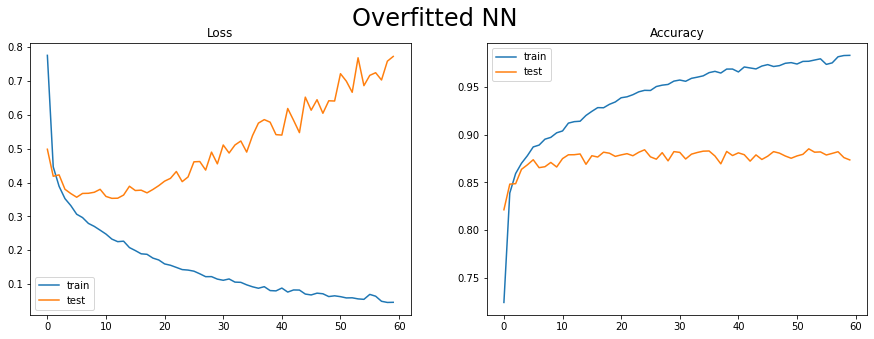

In [ ]:
plot_train_process('Overfitted NN', train_loss, val_loss, val_accuracy, train_accuracy)

In [ ]:
print('train loss: {:.4f}\ntest loss: {:.4f}\n'.format(train_loss[-1], val_loss[-1]))
print('train accuracy: {:.4f}\ntest accuracy: {:.4f}'.format(train_accuracy[-1], val_accuracy[-1]))

train loss: 0.0461
test loss: 0.7724

train accuracy: 0.9832
test accuracy: 0.8735


**<font color=blue>Conclusions</font>**

- The overfitting is quite clear:
  - Test loss not only stops decreasing while the training loss decreases but also worsens with the number of epochs.
  - Test accuracy reaches a plateau while training accuracy gradually improves even for the last iterations.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

**<font color=blue>Observations:</font>**

- In order to perform some experiments we allowed ourselves to change the signature of `FixedNeuralNetwork()`:
  - The first and last layers are allowed to remain the same for all the experiment: nn.Linear and with nn.LeakyReLu() as activation for the output layer.
  - `intermediate_layers` will be the hidden structure that we'll pass as argument and that depends on whether we're adding Dropout only, BN only or Dropout and BN combined.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, intermediate_layers, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        network = [nn.Flatten(), nn.Linear(input_shape, 500)] + intermediate_layers + [nn.Linear(100, num_classes),nn.LeakyReLU()]
        self.model = nn.Sequential(*network)
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

**<font color=blue> Experiment 1:</font> Dropout Only.**

In [ ]:
layers_dropout = [
                        nn.LeakyReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(500, 200),
                        nn.LeakyReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(200, 100),
                        nn.LeakyReLU(),
]

In [ ]:
torchsummary.summary(FixedNeuralNetwork(layers_dropout).to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
         LeakyReLU-3                  [-1, 500]               0
           Dropout-4                  [-1, 500]               0
            Linear-5                  [-1, 200]         100,200
         LeakyReLU-6                  [-1, 200]               0
           Dropout-7                  [-1, 200]               0
            Linear-8                  [-1, 100]          20,100
         LeakyReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
        LeakyReLU-11                   [-1, 10]               0
Total params: 513,810
Trainable params: 513,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
del model, opt, loss_func
model = FixedNeuralNetwork(layers_dropout).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here

In [ ]:
del train_loss, val_loss, train_accuracy, val_accuracy
n_epochs = 60
train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, small_train_loader, test_loader, loss_func, opt, n_epochs)

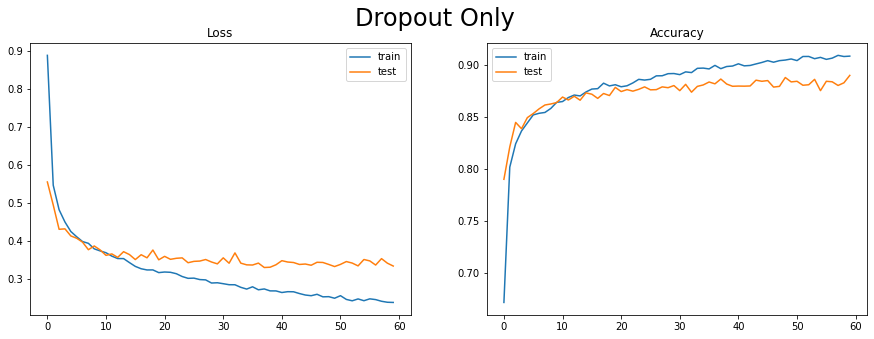

In [ ]:
plot_train_process("Dropout Only", train_loss, val_loss, val_accuracy, train_accuracy)

In [ ]:
print('train loss: {:.4f}\ntest loss: {:.4f}\n'.format(train_loss[-1], val_loss[-1]))
print('train accuracy: {:.4f}\ntest accuracy: {:.4f}'.format(train_accuracy[-1], val_accuracy[-1]))

train loss: 0.2390
test loss: 0.3346

train accuracy: 0.9081
test accuracy: 0.8896


**<font color=blue>Conclusions</font>**

- The training loss and training are slightly worse than the case without dropout. This make sense, since with dropout we expect the network to reduce its tendency to fit noise in the training data.
- Test loss significantly improved from the previous case: it doesn't bounce up and seems to reach a plateau at around $0.4$.
- Test accuracy also improved and it much closer to traing accuracy than in the previous case.


**<font color=blue> Experiment 2:</font> Batch Normalization Only.**

In [ ]:
layers_bn = [
                        
                        nn.LeakyReLU(),
                        nn.BatchNorm1d(500),
                        
                        
                        nn.Linear(500, 200),

                        nn.LeakyReLU(),
                        nn.BatchNorm1d(200),
                        
             
                        nn.Linear(200, 100),
                        nn.LeakyReLU(),
]

In [ ]:
torchsummary.summary(FixedNeuralNetwork(layers_bn).to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
         LeakyReLU-3                  [-1, 500]               0
       BatchNorm1d-4                  [-1, 500]           1,000
            Linear-5                  [-1, 200]         100,200
         LeakyReLU-6                  [-1, 200]               0
       BatchNorm1d-7                  [-1, 200]             400
            Linear-8                  [-1, 100]          20,100
         LeakyReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
        LeakyReLU-11                   [-1, 10]               0
Total params: 515,210
Trainable params: 515,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
del model, opt, loss_func
model = FixedNeuralNetwork(layers_bn).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here

In [ ]:
del train_loss, val_loss, train_accuracy, val_accuracy
n_epochs = 60
train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, small_train_loader, test_loader, loss_func, opt, n_epochs)

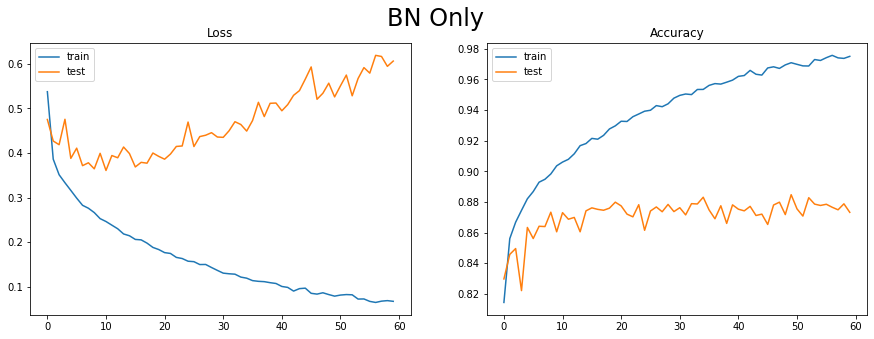

In [ ]:
plot_train_process("BN Only", train_loss, val_loss, val_accuracy, train_accuracy)

In [ ]:
print('train loss: {:.4f}\ntest loss: {:.4f}\n'.format(train_loss[-1], val_loss[-1]))
print('train accuracy: {:.4f}\ntest accuracy: {:.4f}'.format(train_accuracy[-1], val_accuracy[-1]))

train loss: 0.0684
test loss: 0.6150

train accuracy: 0.9732
test accuracy: 0.8717


**<font color=blue>Conclusions</font>**

- In this case Batch Norm doesn't provide any improvements. This may be due to:
  - batch size ($128$) is to small which bring unstability to BN.
  - The chosen network structure chosen doesn't allow for improvements through BN.
  - One way to see it is this (for simplicity, let the layers output a number for each single observation): After LeakyReLU, some output instances from the previous FC layer are dropped down to (almost) zero (the ones for which its FC output is negative). This
    - 1) modifies the underlying data distribution the mean and variance for BN are calculated upon, and
    - 2) causes some weights for the subsequent FC layer to be quite large, compensanting for the smaller values received as inputs (the ones the BN layer gave). For large input value will be the other way around. During testing BN will try to give the test set the same distribution as the one it saw during training (by applying moving mean and variance), but there is no guarantee that the test data will be normalize $\implies$ any slight deviation from normalization will produce some values for which the computation for the next FC will set the values off the range (some weights are too small, other too big). All this adds up as we go deeper into the network.

**<font color=blue> Experiment 3:</font> Dropout + Batch Norm.**


In [ ]:
layers_do_bn = [
                        nn.BatchNorm1d(500),
                        nn.LeakyReLU(),
                        nn.Dropout(0.5),
                        

                        nn.Linear(500, 200),
                
                        nn.BatchNorm1d(200),
                        nn.LeakyReLU(),
                        nn.Dropout(0.5),
             
                        nn.Linear(200, 100),
                        nn.LeakyReLU(),
]

In [ ]:
torchsummary.summary(FixedNeuralNetwork(layers_do_bn).to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
       BatchNorm1d-3                  [-1, 500]           1,000
         LeakyReLU-4                  [-1, 500]               0
           Dropout-5                  [-1, 500]               0
            Linear-6                  [-1, 200]         100,200
       BatchNorm1d-7                  [-1, 200]             400
         LeakyReLU-8                  [-1, 200]               0
           Dropout-9                  [-1, 200]               0
           Linear-10                  [-1, 100]          20,100
        LeakyReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 10]           1,010
        LeakyReLU-13                   [-1, 10]               0
Total params: 515,210
Trainable params:

In [ ]:
del model, opt, loss_func
model = FixedNeuralNetwork(layers_do_bn).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here

In [ ]:
del train_loss, val_loss, train_accuracy, val_accuracy
n_epochs = 60
train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, small_train_loader, test_loader, loss_func, opt, n_epochs)

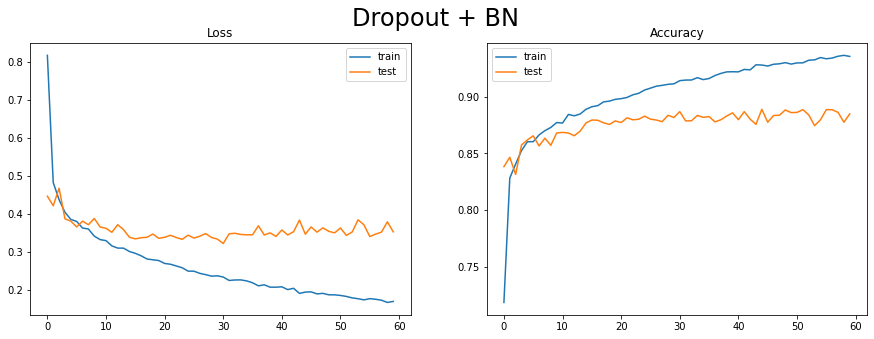

In [ ]:
plot_train_process("Dropout + BN", train_loss, val_loss, val_accuracy, train_accuracy)

In [ ]:
print('train loss: {:.4f}\ntest loss: {:.4f}\n'.format(train_loss[-1], val_loss[-1]))
print('train accuracy: {:.4f}\ntest accuracy: {:.4f}'.format(train_accuracy[-1], val_accuracy[-1]))

train loss: 0.1699
test loss: 0.3529

train accuracy: 0.9356
test accuracy: 0.8849


**<font color=blue>Conclusions:</font>**

- The model does better than using BN alone.
- It doesn't do better than using dropout alone. In fact, here the test loss and accuracy are comparable to the case using only dropout, but the train loss and accuracy improves with each iteration, which shows that the network is overfitting the train set.
- This performance difference between the dropout+BN and dropout-only version may also be due to the _variance shift_ caused be incorporating both techniques simultaneously into the network, problem that also worsens as we go deeper into the network. This difference is in accordance to the results presented in this [paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf).

### Conclusions:
_Write down small report with your conclusions and your ideas._

- Mostly my conclusions are written above after each experiment.
- Another conclusion for myself is that the usefulness of dropout, batch norm and maybe other regularization techniques is that they are not magic tricks to be blindly applied everywhere or that they'll bring improvementes every time they are bring to the table, even in the cases where I'm the one doing something wrong.